In [1]:

from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s

In [2]:
import inspect
import dyna_env_drifttype_gradual
# 显示模块中的所有成员
print(dir(dyna_env_drifttype_gradual))
from dyna_env_drifttype_gradual import TaskEnv_driftype_gradual
env = TaskEnv_driftype_gradual()
print(env)

['Discrete', 'List', 'TaskEnv_driftype_gradual', 'Tuple', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'action_penalty_dict', 'ast', 'change_frequencies', 'change_states_severity', 'create_transition', 'drift_transition', 'gymnasium', 'np', 'pd', 'perturb_probs', 'random', 'repeat', 'seeding', 'syn_state_action']
<TaskEnv_driftype_gradual instance>


/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


In [3]:
class Q_learning_Agent():
    def __init__(self,
                 env: TaskEnv_driftype_gradual,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.2,
                 discount_factor: float = 1) -> int:
        self.epsilon = exploration_rate  # A random agent "explores" always, so epsilon will be 1
        self.alpha = learning_rate  # A random agent never learns, so there's no need for a learning rate
        self.gamma = discount_factor  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros((4,7), dtype=float) #+3 
        #self.q_table = np.zeros((4,7), dtype=float) #7个state 10个action

        self.actions = env.action_space
        
    def change_qtable(self):
        self.q_table = np.zeros((8,10),dtype=float) #state have TAU
        return

    def select_action(self, state, use_greedy_strategy: bool = False) -> int:
        #print("action space:",env.action_space)
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x = env.observation_space.columns.to_list().index(state)
        max_val = np.max(self.q_table[x, :])
        find_max_val = np.where(self.q_table[x, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):        
        # Helper variables to easily get the indices of the value
        x = env.observation_space.columns.to_list().index(state)
        next_max_val = 0
        if next_state != 'Tau':
           # print("length of observation space colummns",len(env.observation_space.columns))
            x_ = env.observation_space.columns.to_list().index(next_state)
            #print(x_)
            # Get the maximum value
            next_max_val = np.max(self.q_table[x_, :])
        # Update the value in the q-table using Q(S,A) <- Q(S,A) + alpha(R + gamma(max action value) - Q(S,A))
        self.q_table[x, action] += self.alpha * (reward + (self.gamma*next_max_val) - self.q_table[x, action])


In [4]:
np.shape(env.observation_space)

(7, 4)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(apply_drift=False,add_actions=0, change_at_states=['va', 'po', 'sib', 'pp'], drift_dis_type='similar',intensity = 0.5,drift_type='gradual'):
    """运行单个实验并返回奖励历史"""
    env = TaskEnv_driftype_gradual()
    agent = Q_learning_Agent(env)
    # 实验参数
    total_episodes = 1000
    drift_episode = 500  # 在第50个episode触发drift
    reward_history = []
    
    for episode in range(total_episodes):
        # 应用drift
        if apply_drift and episode == drift_episode:
            env.set_flag()
            env.drift(add_actions, change_at_states, drift_dis_type,intensity, drift_type)  # 仅改变转移概率
            print(f"Drift applied at episode {episode}")

        if drift_type == 'gradual' and episode == drift_episode+100:
            #swap to another distribution after 100 episode
            env.drift_swap = True
        
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
        
        reward_history.append(episode_reward)
    return reward_history



def run_multiple_trials(apply_drift=False, num_runs=5):
    """多次运行实验并返回平均结果"""
    all_results = []
    
    for _ in tqdm(range(num_runs)):
        results = run_experiment(apply_drift)
        all_results.append(results)
    
    # 计算统计量
    avg_rewards = np.mean(all_results, axis=0)
    std_rewards = np.std(all_results, axis=0)
    
    return avg_rewards, std_rewards
def reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift):
    plt.figure(figsize=(12, 6))

    # 绘制无drift曲线
    plt.plot(avg_no_drift, label='No Drift', color='blue')
    plt.fill_between(range(len(avg_no_drift)),
                    avg_no_drift - std_no_drift,
                    avg_no_drift + std_no_drift,
                    alpha=0.2, color='blue')

    # 绘制有drift曲线
    plt.plot(avg_with_drift, label='With Drift', color='red')
    plt.fill_between(range(len(avg_with_drift)),
                    avg_with_drift - std_with_drift,
                    avg_with_drift + std_with_drift,
                    alpha=0.2, color='red')
    # 标记drift发生位置
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    plt.text(10, min(avg_no_drift)*0.9, 'Drift Start', rotation=0, color='gray')

    # 图表装饰
    plt.title('Average Reward with and without Concept Drift (5 runs average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return


Running experiments without drift...


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
 20%|██  


Running experiments with drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 20%|██        | 1/5 [00:00<00:02,  1.86it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 40%|████      | 2/5 [00:01<00:01,  1.89it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 60%|██████    | 3/5 [00:01<00:01,  1.95it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 80%|████████  | 4/5 [00:02<00:00,  1.94it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


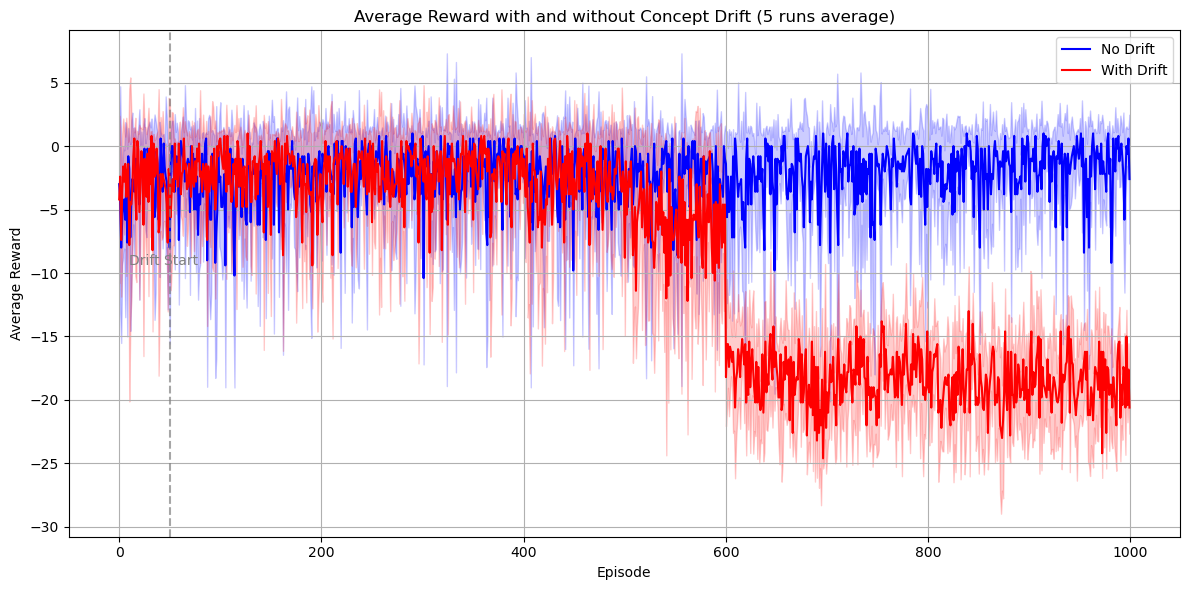

In [6]:
# 运行无drift和有drift的实验 , random sudden drift
print("Running experiments without drift...")
avg_no_drift, std_no_drift = run_multiple_trials(apply_drift=False)
print("\nRunning experiments with drift...")
avg_with_drift, std_with_drift = run_multiple_trials(apply_drift=True)
reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift)

Running experiments without drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容


Running experiments with drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 20%|██        | 1/5 [00:00<00:02,  1.54it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 40%|████      | 2/5 [00:01<00:01,  1.59it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 60%|██████    | 3/5 [00:01<00:01,  1.51it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 80%|████████  | 4/5 [00:02<00:00,  1.59it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype_gradual.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


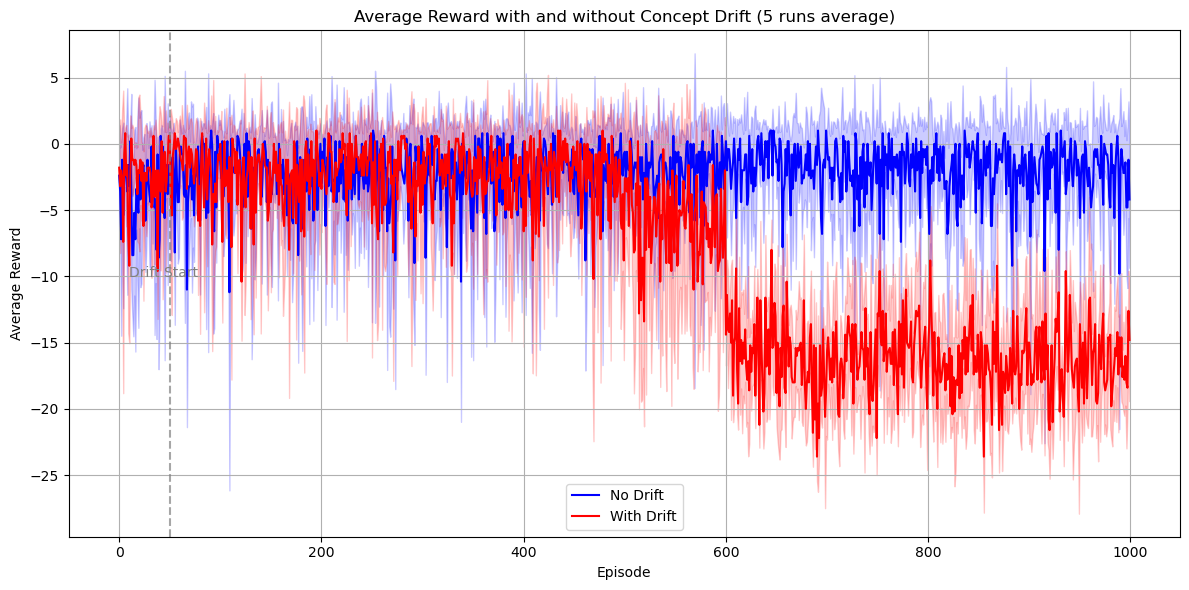

In [8]:
print("Running experiments without drift...")
avg_no_drift, std_no_drift = run_multiple_trials(apply_drift=False)
print("\nRunning experiments with drift...")
avg_with_drift, std_with_drift = run_multiple_trials(apply_drift=True)
reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift)